# Liesel-GAM Demo Notebook

## Setup and Imports

In [7]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import liesel_gam as gam
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

from smoothcon import SmoothCon

In [8]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

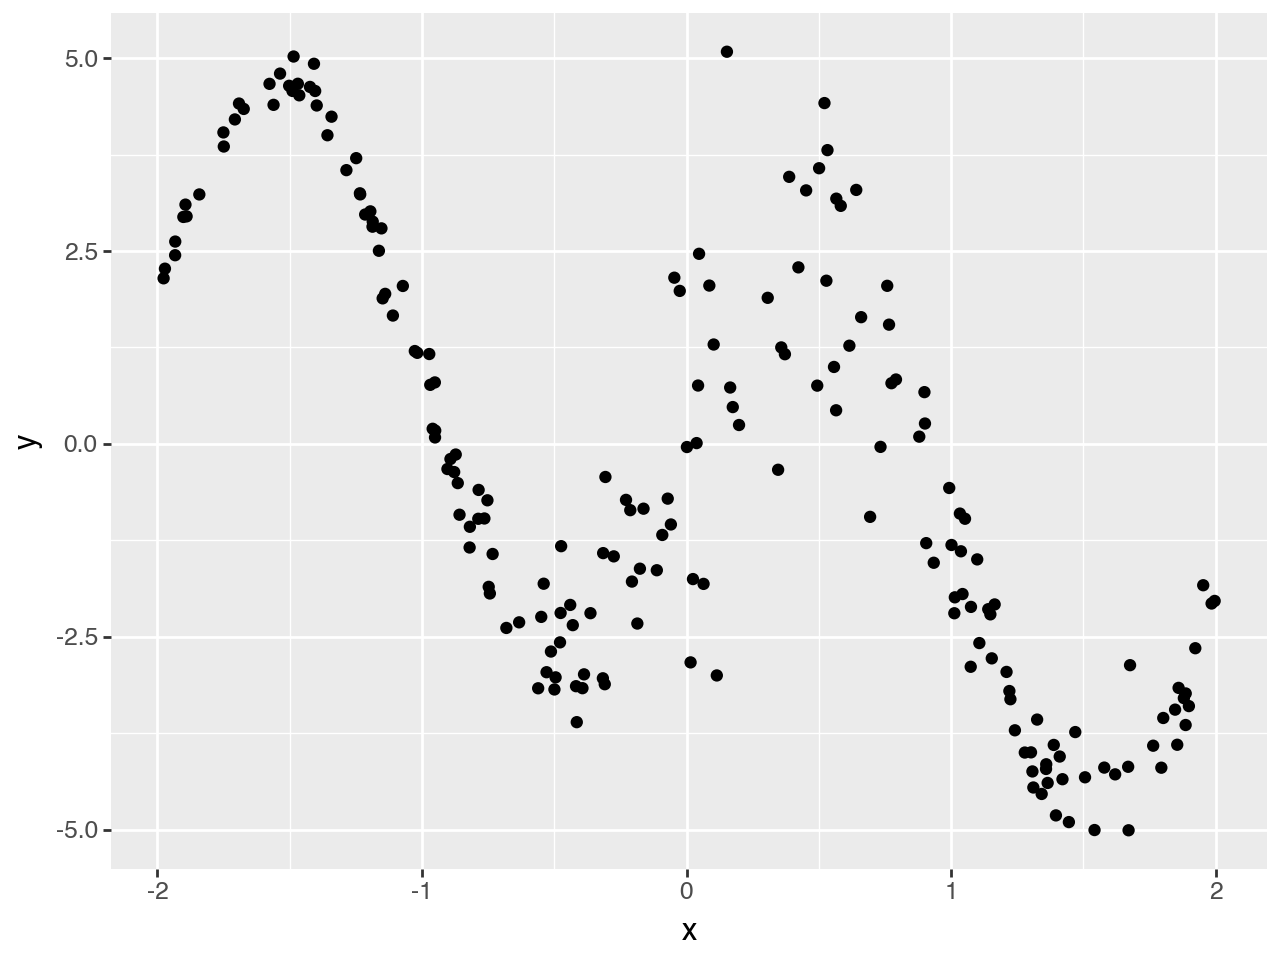

In [9]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [10]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=y,
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Set up intercepts

In [11]:
loc += gam.Intercept(name="$\\beta_0$", inference=gs.MCMCSpec(gs.IWLSKernel))
scale += gam.Intercept(name="$\\gamma_0$", inference=gs.MCMCSpec(gs.IWLSKernel))

### Set up basis an penalty matrices

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [12]:
smooth_x = SmoothCon(
    # this string is the R code you *would* call in mgcv for this term
    spec="s(x, bs='ps', k=20, m=c(3,2))",
    data=df,
)

xvar = lsl.Var.new_obs(x, name="x")
x_basis = gam.Basis(value=xvar, basis_fn=smooth_x)

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [13]:
loc += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=smooth_x.penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(x)",
    variance_name="$\\tau^2_m$",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

scale += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=smooth_x.penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(x)",
    variance_name="$\\tau^2_s$",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="x_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


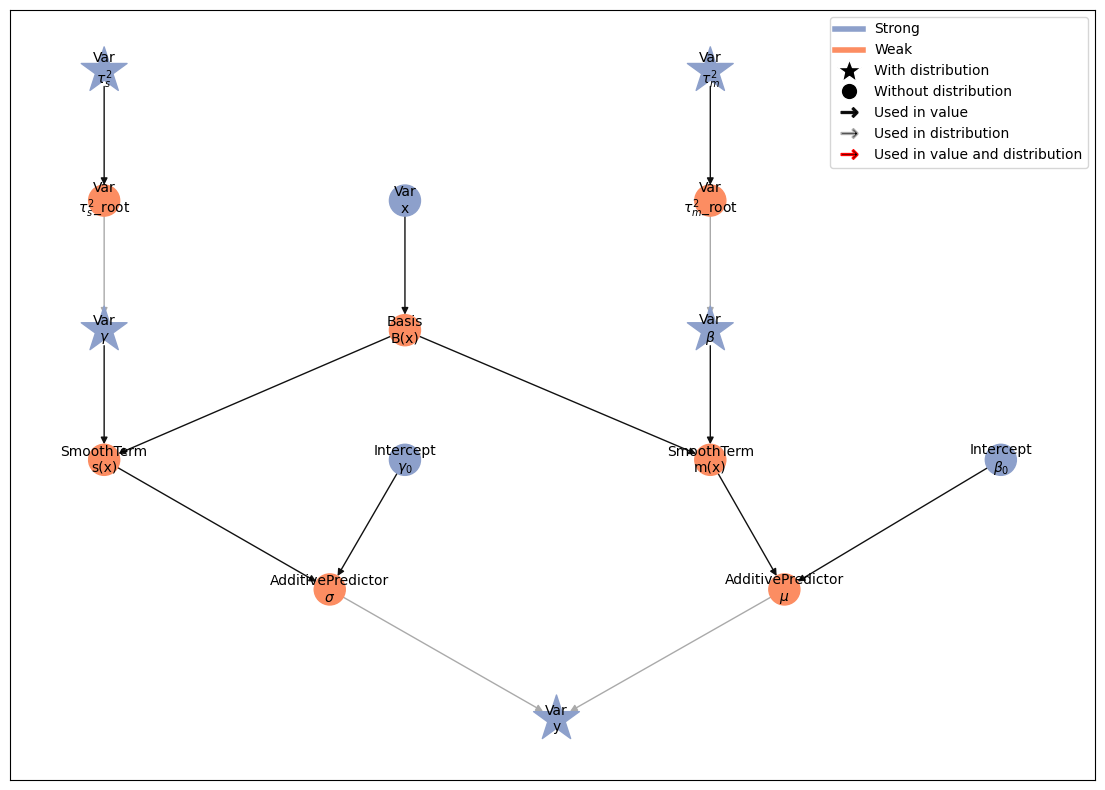

In [14]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [15]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\tau^2_s$', '$\\gamma_0$', '$\\beta$', '$\\tau^2_m$', '$\\beta_0$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.66chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 121.12chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:0

### MCMC summary

In [16]:
summary = gs.Summary(results)
summary

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
$\beta$    (0,)   kernel_03  0.271782  0.449856 -0.440817  0.254148  1.038842   
           (1,)   kernel_03  0.002156  0.404799 -0.664868  0.003790  0.669088   
           (2,)   kernel_03  0.455529  0.432289 -0.198251  0.430018  1.223431   
           (3,)   kernel_03  0.191419  0.405631 -0.450860  0.180714  0.861657   
           (4,)   kernel_03  0.154931  0.368988 -0.436292  0.149726  0.774184   
           (5,)   kernel_03  0.158773  0.346271 -0.418506  0.151039  0.721688   
           (6,)   kernel_03 -0.027063  0.330162 -0.561423 -0.029711  0.512210   
           (7,)   kernel_03  0.079991  0.308518 -0.424529  0.085067  0.590089   
           (8,)   kernel_03  0.080729  0.298772 -0.384865  0.072459  0.572475   
           (9,)   kernel_03  0.121421  0.259254 -0.290823  0.116818  0.551719   
           (10,)  kernel_03  0.116081  0.250208 -0.293292  0.125031  0.511260   
           (11,)  kernel_03 -0.131663  0.210987 -0.481031 -0.132446  0.212026   
           (12,)  kernel_03  0.300836  0.188683 -0.019812  0.302470  0.600302   
           (13,)  kernel_03 -0.040096  0.146914 -0.277160 -0.040057  0.202342   
           (14,)  kernel_03  1.361168  0.114609  1.176375  1.357226  1.551186   
           (15,)  kernel_03 -0.042308  0.074215 -0.164565 -0.042529  0.077978   
           (16,)  kernel_03  0.124252  0.043309  0.055604  0.123429  0.195556   
           (17,)  kernel_03  0.015405  0.017618 -0.013680  0.015400  0.043873   
           (18,)  kernel_03 -0.309272  0.067558 -0.418009 -0.310448 -0.197545   
$\beta_0$  ()     kernel_05 -0.319174  0.060858 -0.416916 -0.320000 -0.216636   
$\gamma$   (0,)   kernel_00  0.015693  0.120515 -0.171454  0.010544  0.210909   
           (1,)   kernel_00  0.017277  0.119287 -0.166434  0.015729  0.211988   
           (2,)   kernel_00  0.003898  0.117962 -0.188347  0.005046  0.199400   
           (3,)   kernel_00  0.005468  0.114512 -0.180145  0.005073  0.192624   
           (4,)   kernel_00 -0.025830  0.118953 -0.221236 -0.021121  0.157106   
           (5,)   kernel_00  0.010321  0.112933 -0.173471  0.009620  0.191935   
           (6,)   kernel_00 -0.036336  0.116827 -0.231109 -0.031429  0.141828   
           (7,)   kernel_00  0.055684  0.112006 -0.113568  0.050006  0.245608   
           (8,)   kernel_00  0.039767  0.107150 -0.124331  0.034649  0.220136   
           (9,)   kernel_00  0.001922  0.098685 -0.161820  0.000673  0.166558   
           (10,)  kernel_00 -0.005130  0.092064 -0.154251 -0.006359  0.147248   
           (11,)  kernel_00  0.000539  0.088794 -0.143564 -0.001529  0.147451   
           (12,)  kernel_00  0.106302  0.085519 -0.023481  0.102517  0.251588   
           (13,)  kernel_00 -0.098123  0.074372 -0.224889 -0.096926  0.016132   
           (14,)  kernel_00  0.052779  0.060351 -0.045555  0.053109  0.151247   
           (15,)  kernel_00 -0.080512  0.043987 -0.151865 -0.080371 -0.008785   
           (16,)  kernel_00 -0.006290  0.026471 -0.048822 -0.006452  0.035439   
           (17,)  kernel_00 -0.044518  0.011535 -0.063218 -0.044487 -0.025211   
           (18,)  kernel_00  0.136500  0.044901  0.064470  0.136943  0.207193   
$\gamma_0$ ()     kernel_02 -0.634392  0.053496 -0.720629 -0.636068 -0.546242   
$\tau^2_m$ ()     kernel_04  0.245121  0.122604  0.111931  0.215162  0.480395   
$\tau^2_s$ ()     kernel_01  0.014005  0.011376  0.004291  0.010950  0.033396   

                  sample_size     ess_bulk     ess_tail      rhat  
parameter  index                                                   
$\beta$    (0,)          4000  3511.790787  3623.571665  1.000471  
           (1,)          4000  3352.276218  3890.908029  1.000039  
           (2,)          4000  3425.813923  3181.737754  1.000665  
           (3,)          4000  3084.815178  3517.559828  1.000922  
       

### MCMC trace plots

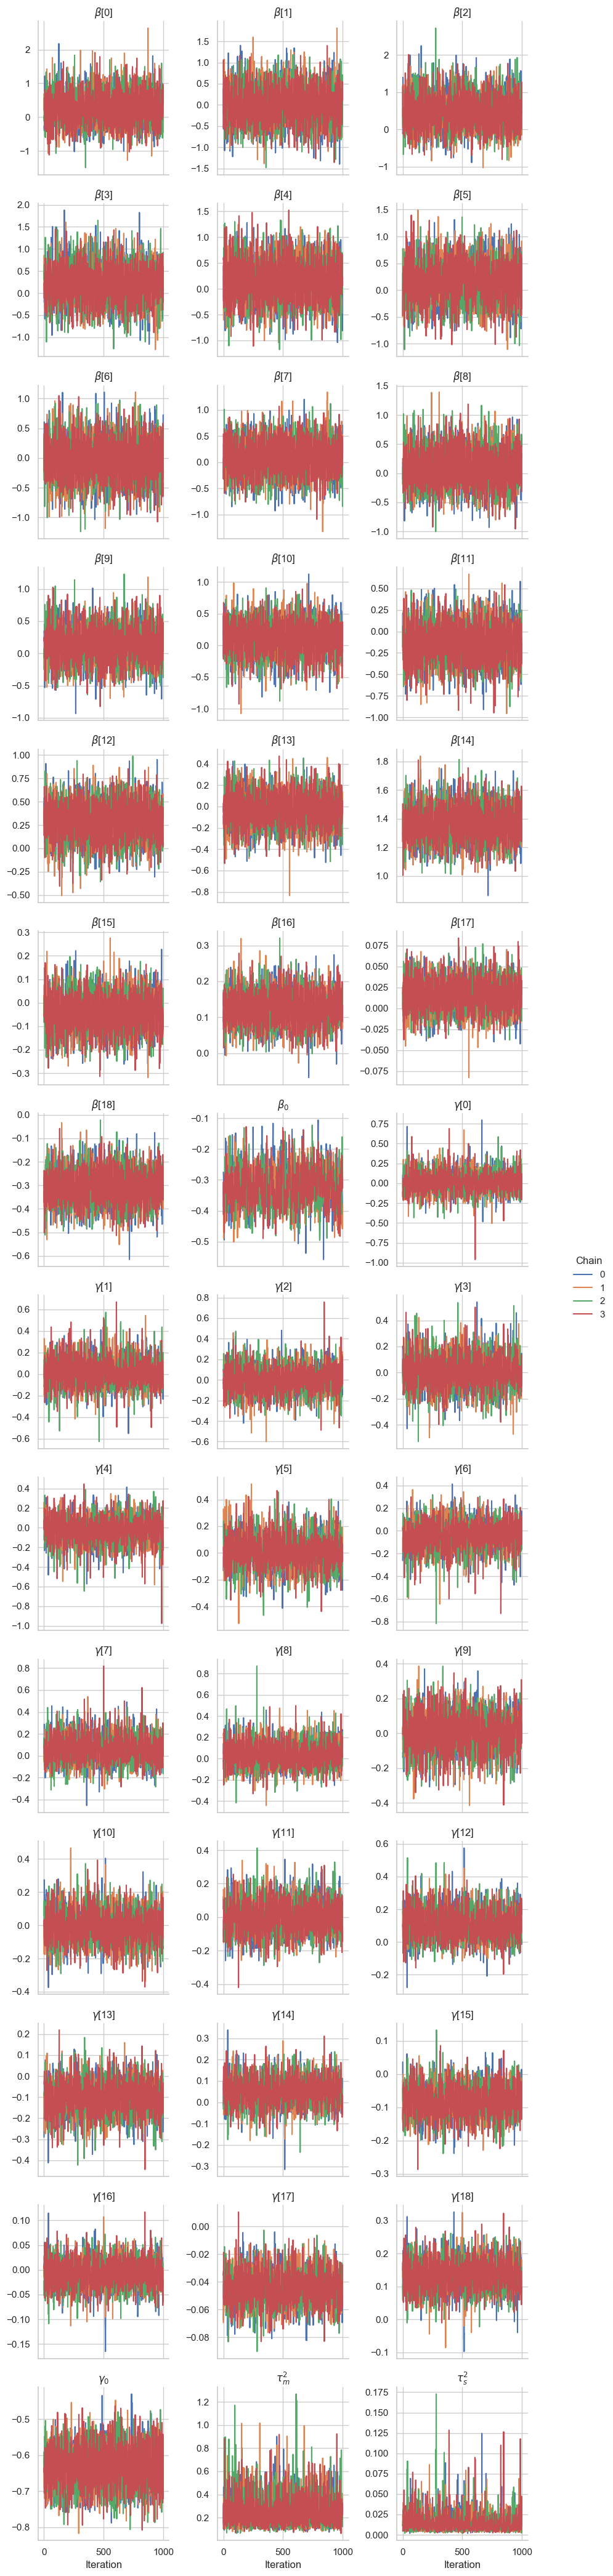

In [17]:
gs.plot_trace(results)

## Predictions

In [18]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

### Predict variables at new x values

In [19]:
x_grid = jnp.linspace(x.min(), x.max(), 200)

predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "s(x)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [20]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.188603,0.004097,0.064010,1.000132,3508.834137,3351.200703,0.001080,0.000961,2.087428,2.187137,2.293536,2.085171,2.290342,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.375280,0.002433,0.049329,1.000219,3463.641312,3379.076459,0.000840,0.000763,2.295908,2.374298,2.455680,2.293415,2.451304,-1.956738
2,$\mu$,$\mu$[2],"(2,)",4000,2.557355,0.001747,0.041795,1.000233,3330.213780,3581.702936,0.000724,0.000630,2.490445,2.556968,2.623972,2.490339,2.623783,-1.936774
3,$\mu$,$\mu$[3],"(3,)",4000,2.734468,0.001659,0.040729,1.000096,3284.129591,3853.284115,0.000710,0.000574,2.668019,2.734743,2.801298,2.665966,2.798840,-1.916810
4,$\mu$,$\mu$[4],"(4,)",4000,2.906257,0.001894,0.043521,0.999917,3323.894315,3835.241603,0.000754,0.000579,2.832930,2.907112,2.975714,2.834527,2.976640,-1.896846


### Plot fitted functions

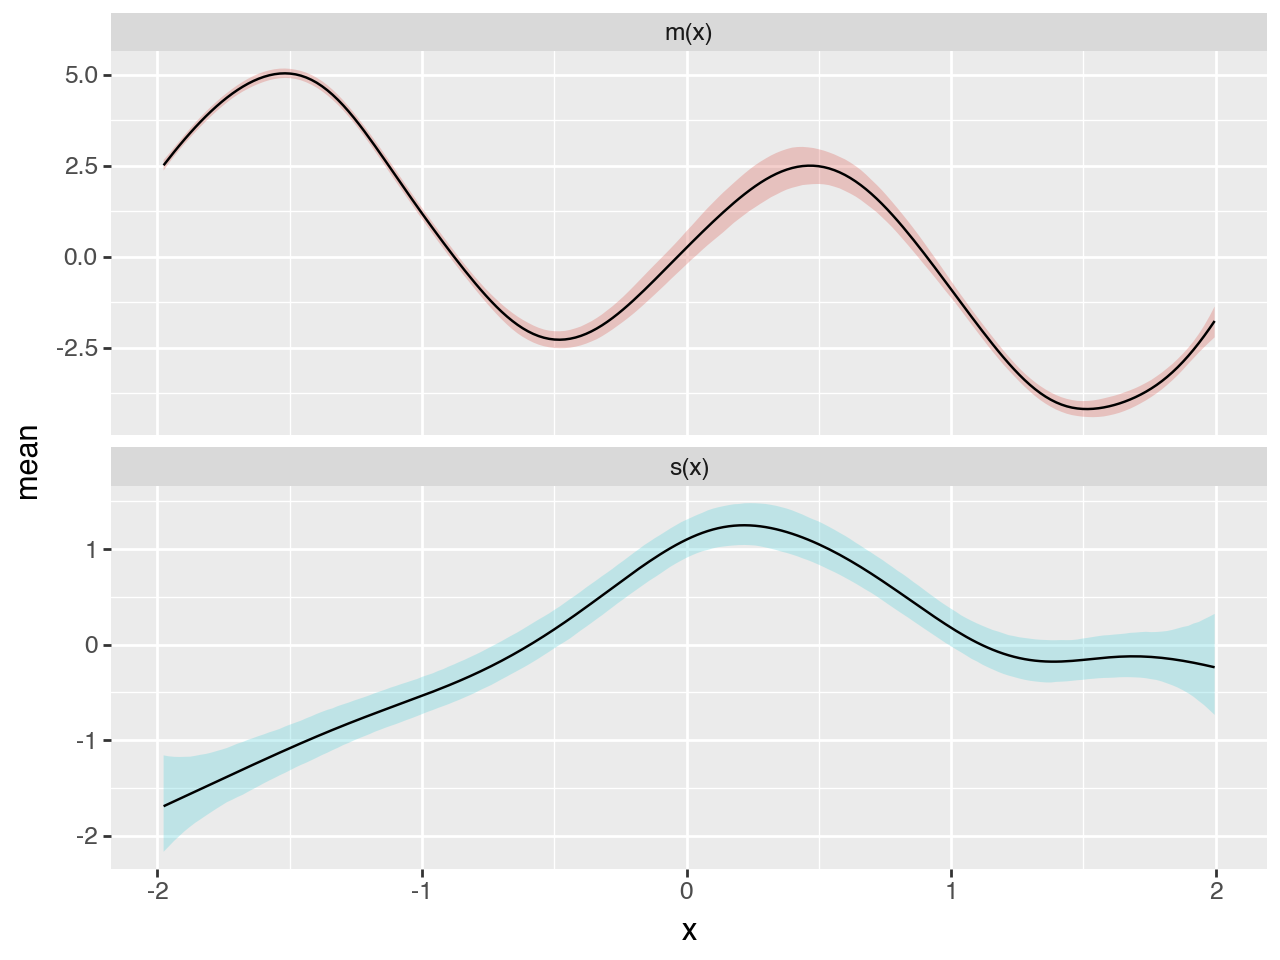

In [21]:
select = predictions_summary["variable"].isin(["s(x)", "m(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

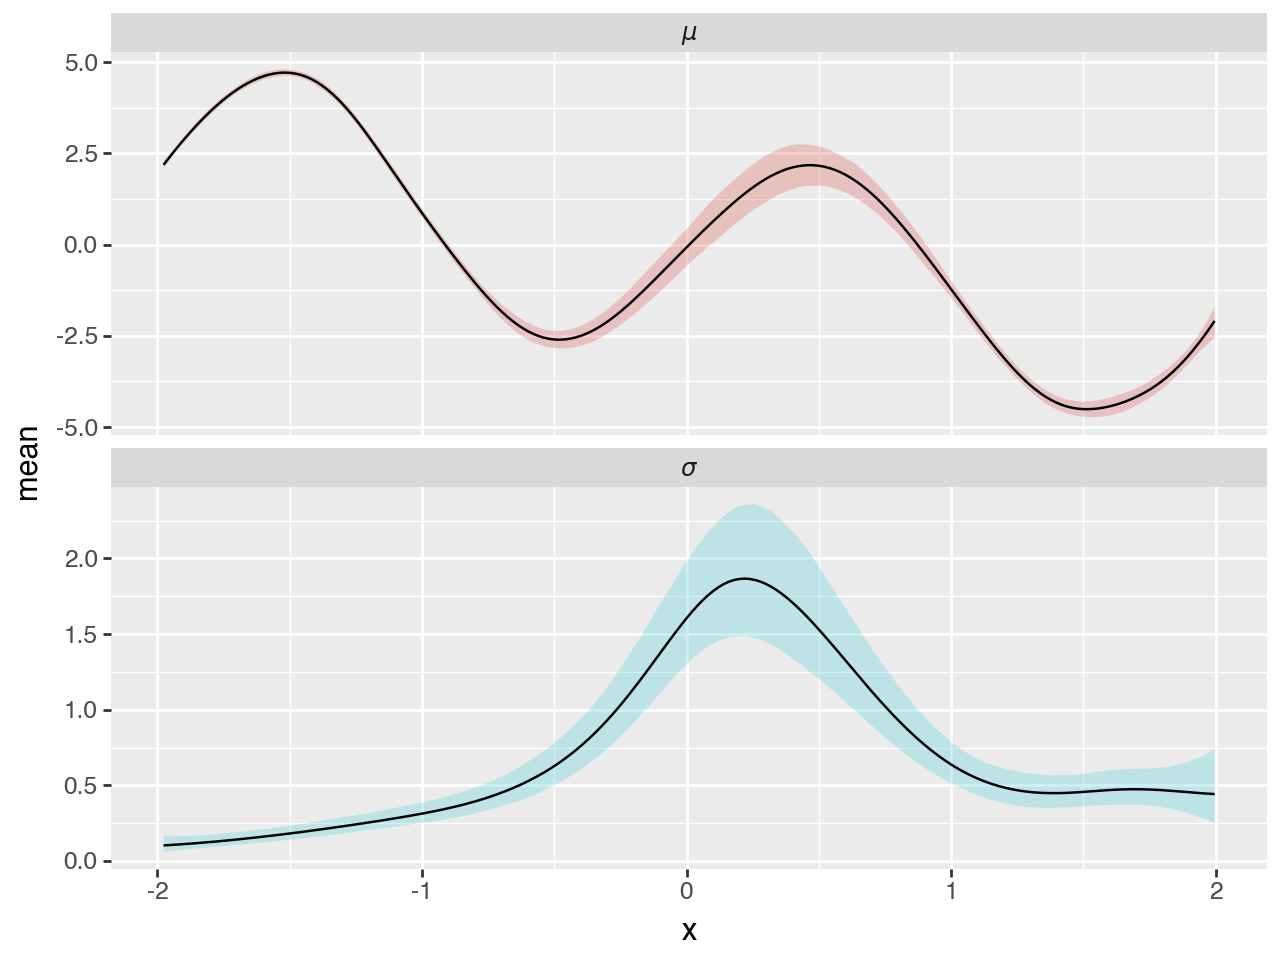

In [22]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

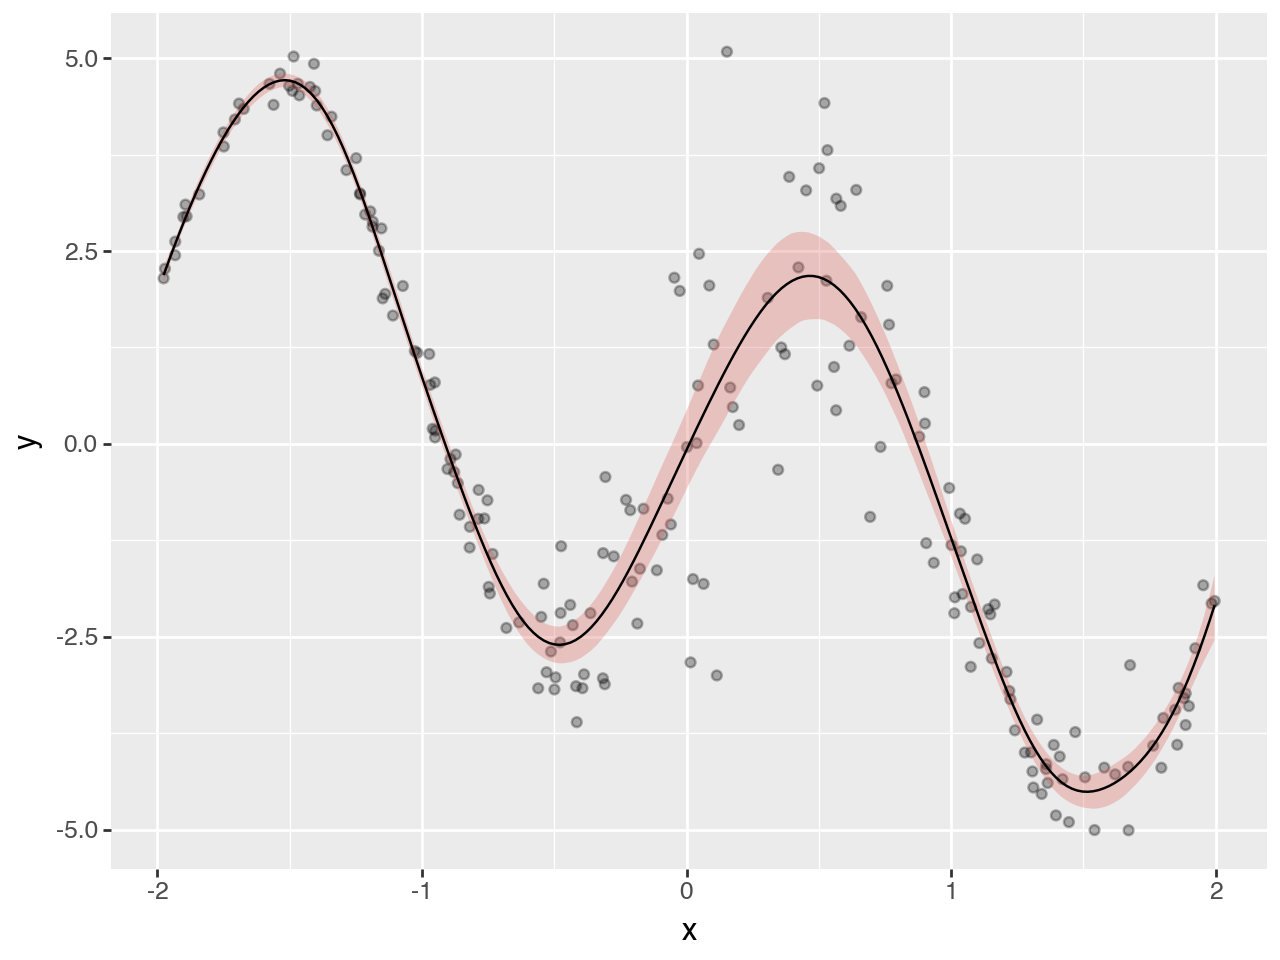

In [23]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [24]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.188603,0.102795,2.085809,2.291398
1,-1.956738,2.375280,0.104793,2.270487,2.480073
2,-1.936774,2.557355,0.106936,2.450420,2.664291
3,-1.916810,2.734468,0.109218,2.625250,2.843686
4,-1.896846,2.906257,0.111633,2.794623,3.017890
...,...,...,...,...,...
195,1.916248,-2.878431,0.451784,-3.330215,-2.426647
196,1.936212,-2.696077,0.449012,-3.145089,-2.247065
197,1.956176,-2.503432,0.446422,-2.949854,-2.057009
198,1.976140,-2.301042,0.444095,-2.745137,-1.856947


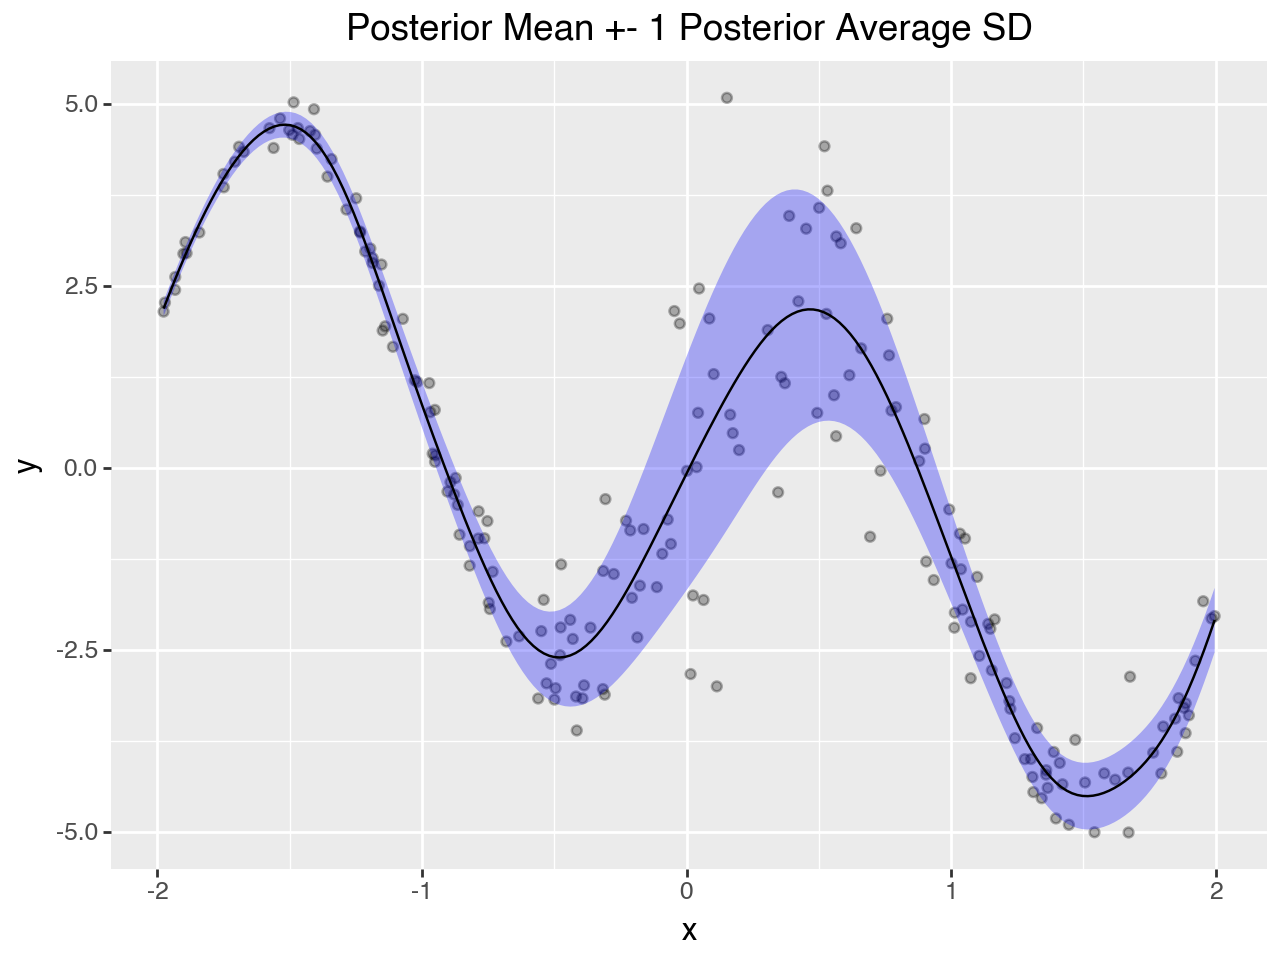

In [25]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [26]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [27]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [28]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

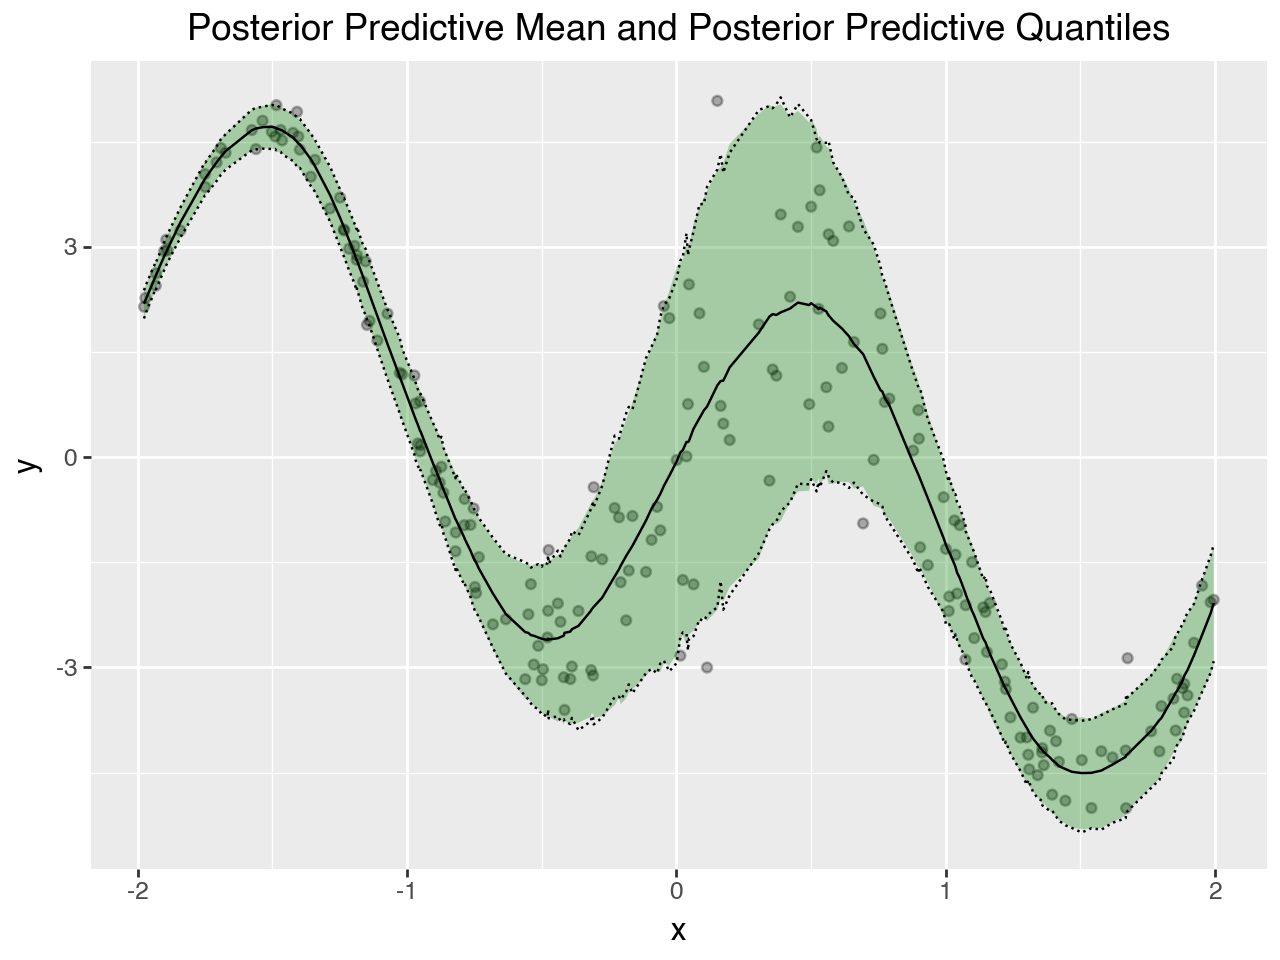

In [29]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

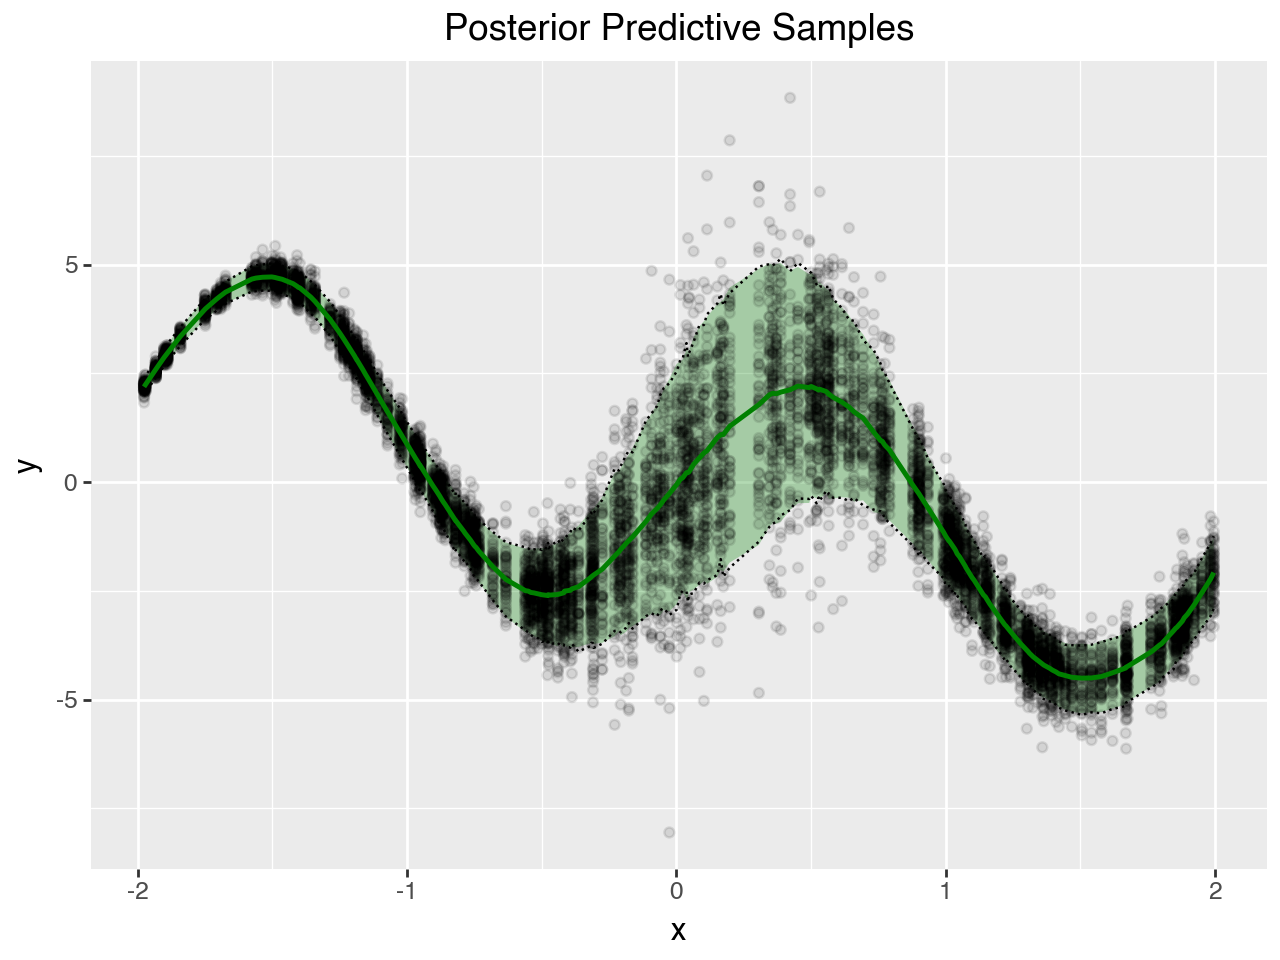

In [30]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)